# Lecture 1: 
- by the end of this lecture we will define and train a neural network, and see everything underneath the hood

## Micrograd intro
- we will do that by building micrograd, which is an autograd (automatic gradient) engine 
- it implements back propagation automatically 
    - back prop is an algorithm that allows us to efficiently evaluate the gradient of some kind of a loss function w.r.t the weights of the neural network
    - we can use it iteratively to tune the weights of that NN to minimize the loss function (therefor improve the accuracy of the network)
    - it is the mathematical core of any Deep learning library (torch, Tf, Jax)

In [1]:
# Lets see an example of using the micrograd library
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


- we see that micrograd allows us to build out mathematical expressions (check the above example)
- we have an expression that we are building out
    - we have 2 inputs `a` and `b`
    - we used them to compute some other variables 
    - `a` and `b` are -4 and 2, but they are wrapped in a Value object (that we will build) 
        - this value object will wrap these values and will be transformed into `c`, `d`, eventually to `e`, `f` , and `g`
        - we can see above that it supports a lot of operations like addition (adding 2 value objects together), subtraction, multiplication, exponentiation, squashing at Zero (relu) and many more
- after building out the expression graph using only `a`, `b` and creating an output value of `g`, micograd in the background will build out this entire mathematical expression 
    - so it will know by `c = a + b` that `c` is also a `value` object and that it the result of an addition operation and the child nodes of `c` (the inputs) are `a` and `b` 

- we can use that layed out mathematical expression to compute the value of `g` eventually (forward pass) and also more importantly, take the `g` Value object and call `g.backward()`
    - this will basically initialize back propagation at the node `g` 
    - it will start at `g` and go backwards through that expression graph and recursively apply the chain rule from calculus 
    - eventually this will calculate the derivative of `g` w.r.t all the internal nodes `e`, `d` and `c` and also w.r.t the inputs `a` and `b`
    - we can see above that we can access these derivatives of g w.r.t any node that led to it

- for example, `a.grad` and `b.grad` which are the derivaties of `g` w.r.t `a` and `b` respectively with values 138 and 645, and these derivatives are very important information, because they tell us how `a` and `b` are affecting g through the mathematical expression 
    - in particular, if we slightly nudge the value of `a` (make it slightly larger), 138 tells us that `g` will grow, and the slope of that growth will be 138, and the slope of growth of `g` if we nudge `b` will be 645
        - for very small nudges -infinitesimally small ranges of the inputs- we can approximate the function `g` as a linear function in that range of the inputs, and the slope of that linear function is the derivative of `g` w.r.t these inputs `a` and `b`
    - that tells us how `g` will respond if we tweak a and b by a tiny amount in the +ve direction 
    - mine: that is why we update the values of these variables by going in the opposite direction (with amount of these derivatives themselves multiplied by the learning rate) 

- the mathematical expression used in the above example is meaningless, and it shows the generality of the micrograd in terms of computations and supported operations (that means we can calculate the derivates of any mathematical expression)
    - but what we really care about are neural networks, and it turns out that they are just mathematical expressions in the end, they take the **input data** and the **weights** of the neural network as inputs, and the output of that mathematical expression is the prediction or the loss
    - so neural networks just happen to be a certain class of mathematical expressions, but back propagation is more general and does't really care about the meaning of the given mathematical expression, it only cares about arbitrarily mathematical expressions, and then we happen to use that machinery for neural networks  

- micrograd is a scalar valued autograd engine for educational purposes, it works on the level of scalars and it would be excessive in production to take neural networks (mathematical expressions) and break them down to these atoms of individual scalars 
    - but actually non of the math changes in modern deep neural networks library, we just take these scalar value objects, package them up into tensors and support tensor-level operations for efficiency and for the use of parallelism in computers
    - so micrograd is really what we need to train neural networks, and everything else is just efficiency
        - and if you think that micrograd would be really complex, that turns out to be wrong :)

- on github there are only 2 files 
    - engine.py 
        - it does not know anyting about neural networks and all it does is taking a mathematical expression and automatically calculates gradients, is only 100 lines of code :)
    - nn.py
        - this is the neural network library built on top of the engine, contains the mathematical expressions of basic neural networks and it is 50 lines of code  :)
        - mine: it is only made to quickly create mathematical expressions of neural networks, which auto grad engine can use 

- mine: this is basically all what we need to train neural networks :) , an autograd engine, and a neural network mathematical expression that takes the data and weights, then use that engine to optimise the weights on that specific data :)))

## understanding derivatives 

In [2]:
import math
import numpy as np
np.random.seed(40)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# derivative of a simple function of 1 variable
def f(x):
    return (3*x**2 - 4*x + 5)

In [4]:
f(3.0)

20.0

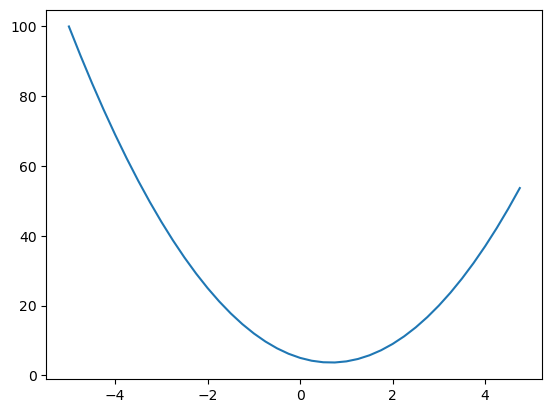

In [5]:
# lets plot this function
x = np.arange(-5,5,0.25) # from -5 to 5 with step 0.25
y = f(x)
plt.plot(x,y)

- what is the derivative of that function at any value of x? if we look up the formula of the derivative 
$$ f'(x) = \lim_{{h \to 0}} \frac{{f(x + h) - f(x)}}{h} $$

as h is an infinitesimally small value, if we slightly bump up the value of x by this h, 
- how does the function **respond** to that? (will it go up or down) 
- and what is the **sensitivity** of that response? (by how much will it go up or down)

basically we calculate the differences before and after that nudge, then we normalise by dividing on the value of that nudge (we don't want it to affect the result)
mathematically, what is the slope of the response at that point

In [6]:
h = 0.0000000001 # a very small number, but not too small because the decimal representation of the numbers are finite and will truncate the small fraction to zero
(f(3.0+h) - f(3.0)) / h

14.000001158365194

- from the graph we already knew that the output will be bumped up (hence the +ve sign), and the sensitivity of that going up is 14
- we can also see that a larger value than that will have higher sensitivity (will go up faster) lets try 10

In [7]:
x = 10.0
((f(x+h) - f(x)) / h)

55.999862524913624

- how about the response at x = -3? from the graph we see that it will go **down** (so we expect a negative sign)

In [8]:
x = -3
((f(x+h) - f(x)) / h)

-21.999966293151374

and the sensitivity turned out to be 22 (go down by that slope) and we can see that if we tried even more negative value, the sensitivity of going down will be larger 

- how about x = 2/3? 

In [9]:
x = 2/3
h = 0.000001
((f(x+h) - f(x)) / h)

2.999378523327323e-06

- we see that at x = 2/3 if we nudge the x up by a small value the function will respond poorly to that (it almost stays the same), and so the slope is 0

- now we will see another example but with 3 inputs (instead of 1)

In [10]:
# a more complex function with multiple variables
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

- we have a mathematical expression of 3 scalar inputs and one output `d`
- we want to look at its derivative w.r.t `a`,`b` and `c` **at their current values** which are 2, -3 and 10 

In [11]:
h = 0.0000000001
d_a = (a+h)*b + c
d_b = a*(b+h) + c
d_c = a*b + (c+h)

print(f' the derivative of d with respect to a is {(d_a - d) / h}')
print(f' the derivative of d with respect to b is {(d_b - d) / h}')
print(f' the derivative of d with respect to c is {(d_c - d) / h}')

 the derivative of d with respect to a is -3.000000248221113
 the derivative of d with respect to b is 2.000000165480742
 the derivative of d with respect to c is 1.000000082740371


- so if we bump up `a`, `d` will **decrease** with a sensitivity of 3(3 times that small value h)
- if we bump up `b` or `c`, `d` will **increase** with a sensitivity of 2 and 1 respectively 

and it makes sense 
- when we bump up `a`, since it is multiplied by a -ve number so the overall value of d will **decrease** (hense the -ve sign) and the sensitivity is 3, 
- if we bump up b (it is negative so it becomes less egative) so the output will **increase** and the sensitivity is 2 -it will be higher by the double of the amount we add-
- if we bump up c, it is a +ve number alone so it will increase and therefore the output will **increase** by sensitivity of 1 -it will be higher by the exact same amount (h) we add - (notice that the sensitivety is less since c is alone unlike b which is multiplied by 2 so the sensitivty will be double)

mine: what does this has to do in the context of neural networks? neural networks are just massive mathematical expressions like the above, the inputs are the **data** and **weights** ,and the output is some **loss function** that we want to minimize (we want to make it smaller) 
- sometimes we can nudge (update) the values of both the data and the weights and sometimes we just nudge the values of the weights so that the loss is minimized given the data 
- so we basically calculate derivatives and if the derivatives is +ve, it means nudging up the variable will increase the loss, or if the derivative is -ve, it means nudging up the values will decrease the loss
    - so we want to nudge down the variables with +ve derivatives and nudge up the variables with -ve derivatives 
    - and we simply do that by variable = variable - derivative 
        - if the derivative is +ve the variable will be nudged down
        - if the derivative is -ve the variable will be nudged up
    - but we actually govern that update with what is called the **learning rate** variable = variable - alpha * derivative
- that was how to use the power of derivatives (knwoing how your variable nudging affects the output) and use it to min or max the output (in the above code we use it to minimize)
    - to maximize the output we will just **add** the derivatives to the variables themselves (multipled by some alpha to govern the step 0.01) variable = variable + alpha * derivative
        - so for the variables with +ve derivatives they will be nudged up (by adding a +ve amount to it)
        - for the variables with -ve derivatives we will nudge them **down** (we said nudging them up decreases the output) by adding a -ve amount to it and make it smaller (more -ve)

## pt1: implement micrograd step by step
- we have seen how derivatives calculations for the mathematical expressions are useful and we now want to build a library that automatically calculates the derivatives (or gradients) for our mathematical expression 

### implementing the Value object 

In [12]:
# # my implementation of the micrograd library
# class Value:
#     # initialization method
#     def __init__(self ,data ,_children=() ,_op = "", label=""): # children is used to keep track of the nodes that produced our node, it is an empty tuple by default, and we will construct it in the operation methods
#         self.data = data
#         self.grad = 0 # we will use this variable to store the gradient of the node, it is initialized to zero which means the node doesn't affect the final outcome by changing it
#         self._prev = set(_children) # that is done for efficiency
#         self._op = _op # we will use this variable to store the operation used to create our node (it will be empty string by default) and we will construct it in the operation methods
#         self.label = label # just to store the name of the variable for visualization purposes
    
    
#     # representation method, which is called when the object is printed
#     def __repr__(self):
#         # if we did not have repr, it will print some ugly cryptic stuff about the location of the object in memory
#         return f"Value:(data={self.data})"
    
#     def __add__(self, other):
#         # create a value object of the sum and return it, when we write a + b python will internally call a.__add__(b)
#         out = Value(self.data + other.data, (self, other) ,"+")
#         # update the gard variables with the local derivatives 
#         self.grad += 1
#         other.grad += 1
#         return out

#     def __mul__(self, other):
#         # create a value object of the sum and return it, when we write a + b python will internally call a.__add__(b)
#         out = Value(self.data * other.data, (self, other) ,"*")
#         self.grad += other.data
#         other.grad += self.data
#         return out
    
#     # we can create more complex functions (tanh instead of its basic components, such as exp mul div and so on) that the basic atomic operations (this is an example of scaling things up, we can create functions at arbitrary points of abstractions) and it is ok as long as we can code its derivative
#     def tanh(self):
#         x = self.data
#         tanhx = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
#         out = Value(tanhx, (self, ), "tanh")
#         self.grad += (1 - tanhx**2)
#         return out
    
#     def backwards(self):
#         for prev in self._prev:
#             if self._prev:
#                 prev.grad *= self.grad
#             prev.backwards()


In [13]:
class Value:
    # initialization method
    def __init__(self ,data ,_children=() ,_op = "", label=""): # children is used to keep track of the nodes that produced our node, it is an empty tuple by default, and we will construct it in the operation methods whenever we make an operation between 2 instances to produce a third (they will be the children of the third)
        self.data = data
        self.grad = 0 # we will use this variable to store the gradient of the node (the gradient of the final output w.r.t this node), it is initialized to zero which means the node doesn't affect the final outcome by changing it
        self.label = label # just to store the name of the variable for visualization purposes
        ## all the following will have values for any instance that is a result of an operation between 2 instances (otherwise they will take default values - empty set () for children, empty string for op and none lambda for backward)
        # store the children that produced the node, it is a set to avoid duplicates
        self._prev = set(_children) # that is done for efficiency
        # store the operation that produced the node
        self._op = _op # we will use this variable to store the operation used to create our node (it will be empty string by default) and we will construct it in the operation methods
        # store the backward function that will be used
        self._backward = lambda: None # it will be a function that will be used to take the gradient of the node -upstream- and propagate it to its previous, it is initialized to an empty function that doesnt do anything and it will stay like that for the leave nodes with no previous
    
    
    # representation method, which is called when the object is printed
    def __repr__(self):
        # if we did not have repr, it will print some ugly cryptic stuff about the location of the object in memory
        return f"Value:(data={self.data})"
    
    def __add__(self, other):
        # we want to support Value object additions (a + b) and also scalar additions (a + 1)
        other = other if isinstance(other,Value) else Value(other) # if other is a value object then keep it the same, and if not, wrap the other -which we will assume to be the data- in a Value object
        # create a value object of the sum and return it, when we write a + b python will internally call a.__add__(b)
        out = Value(self.data + other.data, (self, other) ,"+")
        # let's define the backward function when we call the out object _backward. notice that we create a node through an operation and we create at the same time how to backward its gradient to the nodes that createed it (if we kept doing that then all the nodes will have backward implementation except the leaf nodes that are considered the beginning of the mathematical expression)
        def _backward():
            # we want to take out grad and propagate it to the previous nodes, and in addition we simply route the out grad to the previous nodes
            # in other words, we multipled the upstream (out.grad) with the local gradient (which is always 1 in addition) a = b + c da_db = 1, da_dc = 1
            # notice also that we accumulate to self.grad because it might take derivatves from multiple nodes - that it has affected during Forward prop -
            self.grad += out.grad * 1.0 
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other): # mine: this is called when we do something like a * b, it calls a.__mul__(b)
        other = other if isinstance(other,Value) else Value(other)
        # create a value object of the multiplication and return it, when we write a * b python will internally call a.__mul__(b)
        out = Value(self.data * other.data, (self, other) ,"*")
        def _backward():
            # we do += because we want to accumulate the gradients in case a node is used in multiple operations (otherwise we will overwrite the gradient every single time), because when a variable is used in multiple paths, the gradient will be the sum of the gradients coming from these paths during backpropagation
            self.grad += out.grad * other.data 
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # mine: this happens when we call 3 * a since there is no such thing like 3.__mul__(a) it tries to right multiplicate it (calls a.__rmul__(3)) so self is a and other is 3 and we indeed just call mul code instead of repeating it 
        return self * other # we swapped the operands to be a * 2, so we basically called the __mul__ method of a

    def __neg__(self):
        return self * -1  # negation can be expressed using multiplication
    
    def __sub__(self,other):
        return self + (-other) # mine: subtraction can be expressed using addition and negation
    
    def __rsub__(self,other): 
        return (-self) + other # we did that because subraction does't have substitution property 
        # mine: after failing to find the __sub__ method in the left operand, python will try to call the __rsub__ method in the right operand, so 3-a will be a.__rsub__(3) and we will return -a + 3

    
    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.grad * out.data # out.data is e^x which is the derivative of e^x
        out._backward = _backward 
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += out.grad * (other * (self.data**(other - 1)) )
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        # self / other -> self * (1/other) -> self * (other**-1), basically we just call the pow function in here
        return self * (other**-1)

    def __rtruediv__(self,other):
        return other * self**-1 

    # we can create more complex functions (tanh instead of its basic components, such as exp mul div and so on) that the basic atomic operations (this is an example of scaling things up, we can create functions at arbitrary points of abstractions) and it is ok as long as we can code its derivative
    def tanh(self):
        x = self.data
        tanhx = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        out = Value(tanhx, (self, ), "tanh")
        def _backward():
            self.grad += out.grad * (1 - tanhx**2)
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), "relu")
        def _backward():
            self.grad += out.grad * (out.data > 0)
        out._backward = _backward
        return out
    
    def backward(self):
        # this function will build the topological graph then call _backward() functions for the nodes in reverse (we will call it on the final node like loss.backward())
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # a node is only added to the list of topo after we have gone through all of its children -mine: deepest things in the recursion will finish first- (you're only going to be in the list once all of your children are in the list, and that is how we guarantee the sort of the nodes from left to right)
                topo.append(v)

        build_topo(self) # we will start the topological sort from the node we want to take the gradient of (the loss node)
        self.grad = 1  # the gradient of the final node w.r.t itself is 1 (that is the first upstream gradient)
        for node in reversed(topo):
            node._backward()

Q: when i call out._backward() , how does out have access to self and other? 

A: The out._backward function has access to self and other because of a concept in Python called closures. A closure in Python is a function object that has access to variables from its enclosing lexical scope, even when the function is called outside that scope.

In your code, the backward function is defined inside the __mul__ method, so it has access to self and other from its enclosing scope (the __mul__ method). When you assign backward to out._backward, it retains access to self and other, even when it's called later outside of the __mul__ method.

This is why when you call out._backward(), it can still access and modify self.grad and other.grad. This is a key feature that allows for the accumulation of gradients during backpropagation in neural networks.

#### Example 1

In [14]:
a = Value(2.0 ,label="a")
b = Value(-3.0 ,label="b")
c = Value(10 ,label="c")
a, b, c

(Value:(data=2.0), Value:(data=-3.0), Value:(data=10))

In [18]:
# d = a * b + c # equivalent to (a.__mul__(b)).__add__(c)
# print("The value of d is", d)
# print("The children of d are", d._prev)
# print("The operation that produced d is", d._op)

In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        # adds the node to the set of nodes
        if v not in nodes:
            nodes.add(v)
        # adds each child of the node to the set of edges then calls build on the child (recursion)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    # call it on the root node passed to the trace function
    build(root)
    return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    # we use the memory location of the node as a unique identifier
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for the operation then
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)),  str(id(n2))+n2._op)

  return dot

In [16]:
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"

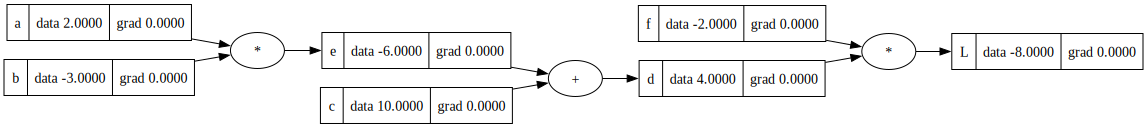

In [17]:
# this will show us the mathematical expression and the value of L (forward prop)
draw_dot(L)

In [18]:
L.backward()

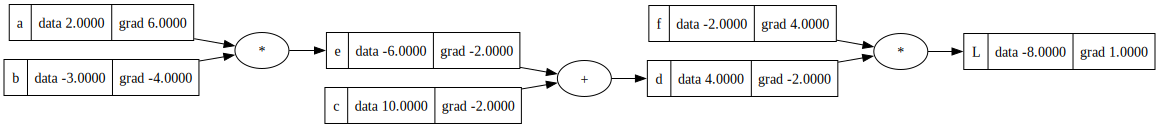

In [19]:
draw_dot(L)

#### Example 2

- a second more realistic example of a neuron, neurons biologically are complicated devices, but we have very simple mathematical models of them
    - it takes some inputs `X`s `(x1, x2, ..........., xn)`
    - and we have some weight synapses `W`s that interact with the inputs multiplicatively `(w1, w2, .................., wn)`
    - then  we sum their multiplication `w . x` and add some bias (like trigger low or up happiness of the neuron regardless of the inputs)
    - then an activation function (some sort of a squashing function)
        - sigmoid
        - tanh
        - relu and so on 
- Multi-layer perceptron is just stacking up these neurons together

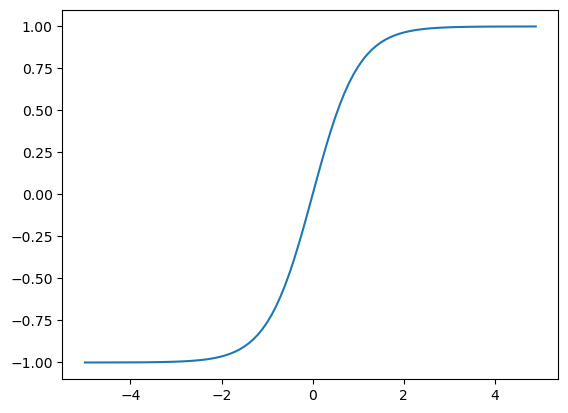

In [20]:
# lets figure out np.tanh()
plt.plot(np.arange(-5,5,0.1),np.tanh(np.arange(-5,5,0.1)))

- as we can see, the inputs as they come in (x-axis) will be squashed between -1 and 1 (on the y-axis)
    - at 0 we will get exactly 0
    - the more +ve the net input, the more +ve the output (but limited to 1)
    - the more -ve the net input z, the function will go down to -1 and plateau out 
- sigmoid is basically the same but squash the -ve to 0 instead 
- the relu will keep the +ve basically the same and squash the -VEs to zero 

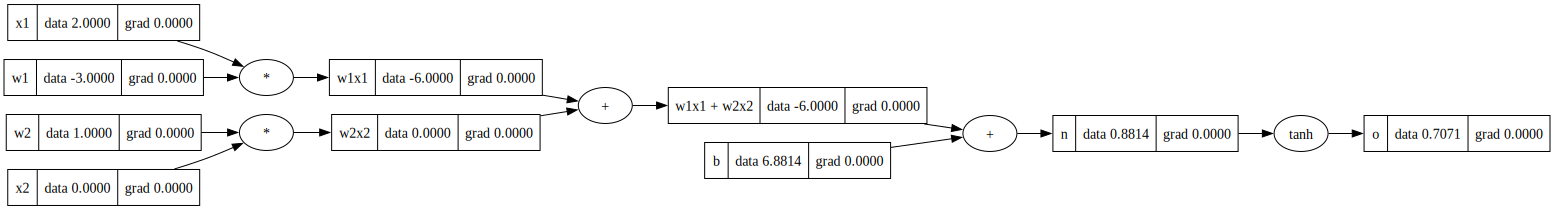

In [21]:
# inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1 and w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432 , label="b")
w1x1 = x1 * w1; w1x1.label = "w1x1"
w2x2 = x2 * w2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1 + w2x2"
n = w1x1w2x2 + b; n.label = "n" # n is the net input
o = n.tanh(); o.label = "o"
draw_dot(o)

- we want to call these backwards in order, meaning we can only call backward for any node before calling all the backwards for all the nodes after it (mine: doing that recursively will not guarantee that, specially if the graph is complicated, or not a tree) 
- this ordering of graph can be achieved using topological sort, which is basically a laying out of the graph such that all edges go only from left to right 

In [22]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        # a node is only added to the list of topo after we have gone through all of its children (you're only going to be in the list once all of your children are in the list, and that is how we guarantee the sort of the nodes from left to right)
        topo.append(v)

build_topo(o) # we will start the topological sort from o
topo

[Value:(data=6.881373587019543),
 Value:(data=-3.0),
 Value:(data=2.0),
 Value:(data=-6.0),
 Value:(data=0.0),
 Value:(data=1.0),
 Value:(data=0.0),
 Value:(data=-6.0),
 Value:(data=0.8813735870195432),
 Value:(data=0.7071067811865477)]

In [23]:
# now we will call .backwards() on the nodes as sorted in the list above, but in reverse as we want to traverse this sorted list backwards
o.grad = 1
for n in reversed(topo):
    n._backward()

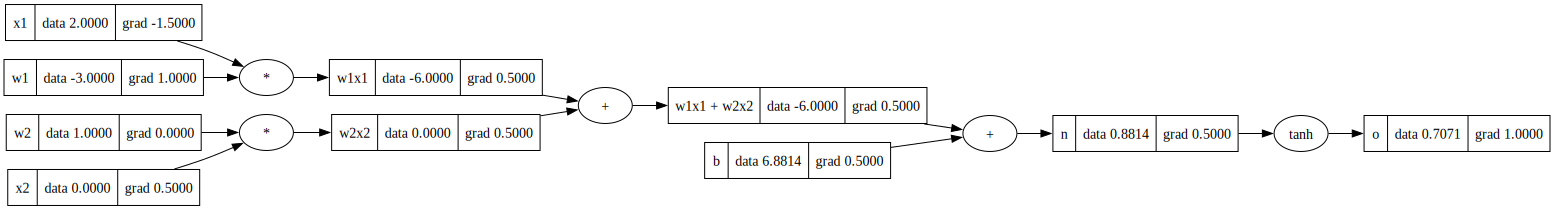

In [24]:
draw_dot(o)

- We have put the previous code (that applies Topological sort and then calling _backward() on each node in reverse) in the `Value` class itself inside the `backward()` method
    - and now all the user has to do is to call `out.backward()` and the gradients will be calculated for all the nodes in the graph

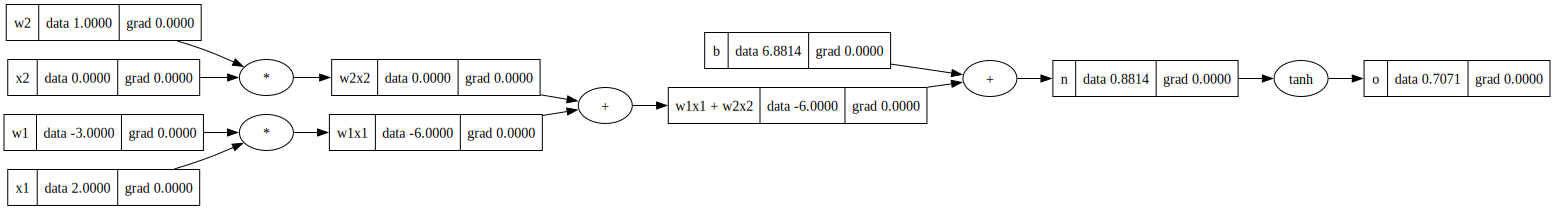

In [25]:
# inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1 and w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432 , label="b")
w1x1 = x1 * w1; w1x1.label = "w1x1"
w2x2 = x2 * w2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1 + w2x2"
n = w1x1w2x2 + b; n.label = "n" # n is the net input
o = n.tanh(); o.label = "o"
draw_dot(o)

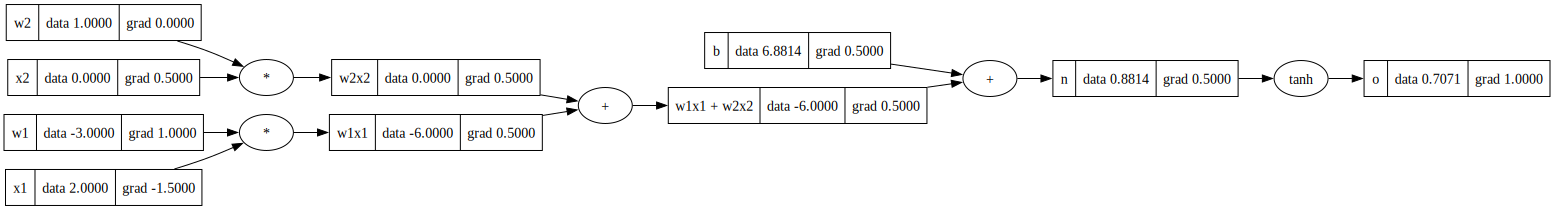

In [26]:
o.backward()
draw_dot(o)

#### Example 3
- in this example we will see the case when a variable is used more than once in the expression (and the derivative will be the sum of the derivatives of all the paths that lead to it)

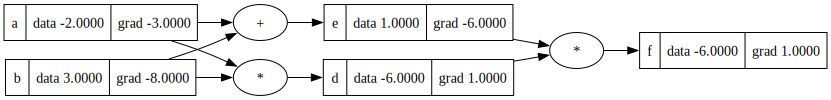

In [27]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label = "d"
e = a + b; e.label = "e"
f = d * e; f.label = "f"
f.backward() # will sort the nodes topologically then call _backward() on each node in reverse order
draw_dot(f)

#### Example 4

In [28]:
a = Value(2.0)
a * 3 # this worked because it is equivalent to a.__mul__(2) which we handled (in the code we checked if other is not a Value object then create a value object for it)

Value:(data=6.0)

In [29]:
3 * a # this won't work because python will call 3.__mul__(a) which is not a thing

Value:(data=6.0)


- the above code won't work because python will call 3.__mul__(a) which is not a thing
    - but we know that a.__mul__(3) is a thing and we handled the case when other is not a value object 
    - the solution is to use the `__rmul__` method which is the right multiplication method (it is called when the left operand does not support the operation), and in this case python will see if a supports right multiplication 
        - so when the left operand is not a value object, python will call the `__rmul__` method of the right operand - will call `a.__rmul__(3)`, and inside it we can perform the logic -a will be self and 3 will be other-

#### Example 5

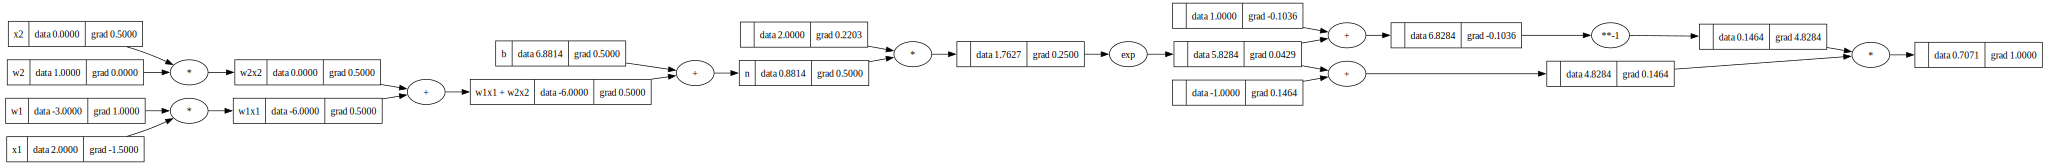

In [30]:
# the same example 2 expression, but breaking the tanh to its components
# inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1 and w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432 , label="b")
w1x1 = x1 * w1; w1x1.label = "w1x1"
w2x2 = x2 * w2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1 + w2x2"
n = w1x1w2x2 + b; n.label = "n" # n is the net input
#o = n.tanh(); o.label = "o"
## tanh = (e^2x - 1)/(e^2x + 1)
e = (2*n).exp() 
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)

- so we can see that we can implement operations on any level as long as we implement its backward code
    - we  implemented the tanh operation and its backward pass
    - we also implemented the tanh in terms of its atomic components (that also have their backward pass implemented)
- all what the expression cares about regarding an operation is how to compute its output given the inputs, and how to compute the local gradient of the output w.r.t the inputs, and that is all what we need to implement in the backward pass

### Equivalent code in PyTorch

- the only difference is that micrograd is a scalar level autograd engine, but pytorch is a tensor level autograd engine (so it is based on n-dimensional arrays of scalars) and it supports a lot of operations on these tensors in parallel (like matrix multiplication, convolution, etc)
    - but the basic idea is the same, we have a mathematical expression that takes the data and the weights and outputs the loss, and we want to calculate the derivatives of the loss w.r.t the weights and the data, and we want to use that information to update the weights and the data to minimize the loss

In [31]:
import torch
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.require_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---------------------")
print("x2 grad", x2.grad.item())
print("w2 grad", w2.grad.item())
print("x1 grad", x1.grad.item())
print("w1 grad", w1.grad.item())

0.7071066904050358
---------------------
x2 grad 0.5000001283844369
w2 grad 0.0
x1 grad -1.5000003851533106
w1 grad 1.0000002567688737


- in the above code we used the tensors to wrap a scalar value (not practical, but just for illustration)
- we casted them to doublle precision (float64), because python's float is a float64 and we want to be consistent with pytorch (the default in pytorch is float32)
- we set the requires_grad to True, because pytorch assumes that leaf tensors (the ones that are not the result of any operation) have requires_grad = False, and we want to calculate the gradients of these tensors so we set it to True
- notice that it is the same as micrograd, we can perform operations, and each tensor has data and grad attributes, and we call item to instead of getting a tensor of a scalar, we just strip the scalar from the tensor

mine: notice how similar Pytorch is to micrograd, regardless of neuralnetworks, they are just mathematical expressions that we want to calculate the derivatives of, but the difference is that pytorch is more efficient and supports tensor level operations (like matrix multiplication, convolution, etc). and it has implemented mathematical expressions of neural networks modules (like linear, conv, etc) and we can use them to build out neural networks and train them (we will also do a similar thing to that shortly)

## Pt2: Implementing a simple neural network
- now that we have the autograd engine, we can build a simple neural network (which as we said is just a mathematical expression)
- we will also do so in a similar way to pytorch (similar to how it designs its neural network module )

### Create a neuron

In [32]:
class neuron:
    def __init__(self, nin, activation = "relu"): # nin is the number of inputs of this neuron
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)] # will initialize the weights to a random unifrom number between -1, 1 with dimension of the nin (as we have a weight for every input)
        self.b = Value(np.random.uniform(-1,1))
        self.activation = activation
    
    # this method will be called when we call the object as a function (we will call it with the inputs x during backprop)
    def __call__(self,x):
        z = sum((xi * wi for xi, wi in zip(x, self.w)), self.b) # start is the initial value of the sum, so we start with the bias
        if self.activation == "relu":
            a = z.relu()
        elif self.activation == "tanh":
            a = z.tanh()
        return a
    
    # let us gather the parameters of the NN so that later we can operate on them simultaneuosly (optimise them), and nudge every one of them to minimize the loss
    # Tensor has the same thing but it returns parameter tensors for each nn module, for us its the parameter scalars
    def parameters(self):
        return self.w + [self.b] # returns the concatenated w and b lists 


In [33]:
x = [2.0,3.0]
# mine: the weights of the single neuron have the same dimension as the input (if something is larger than the other, it will be ignored because of the zip function)
n = neuron(2,activation="relu")
n(x)

Value:(data=0)

In [35]:
n.parameters() # the weights (w1, w2) and the bias

[Value:(data=-0.18462594383942776),
 Value:(data=-0.8892679197762798),
 Value:(data=0.5770697549735053)]

### Create a layer

next we will define a layer 
![Image Description](https://machinelearningcoban.com/assets/14_mlp/ex_nn.png)

- a layer is just a number of neurons, they aren't connected to each other, but each of them is fully connected to the inputs
    - so it is just a set of neurons that are evaluated independently

In [36]:
class Layer:
    def __init__(self, nin, nout, activation = "relu"): # nin is the dimension of the input to each  neuron and nout is the number of neurons (they make up the number of outputs)
        self.neurons = [neuron(nin, activation=activation) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        # # will concatenate the parameters of the single neurons
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters) # extend instead of append because append will append the whole list as one item, but extend extends params with the list items individually
        return params

In [38]:
x = [2.0, -5.0]
l = Layer(2,3, activation="relu")
l(x) # mine: the output of the layer is the output of each neuron in the layer

[Value:(data=0),
 Value:(data=1.3558696643956265),
 Value:(data=3.6671237820565805)]

In [39]:
l.parameters() # the weights of the neurons in the layer

[Value:(data=0.6279370398859911),
 Value:(data=0.41729030432639735),
 Value:(data=-0.9449306393549348),
 Value:(data=0.8085344344634557),
 Value:(data=-0.10019029749274111),
 Value:(data=-0.7621506919949905),
 Value:(data=0.6706003518942925),
 Value:(data=-0.5955035474304318),
 Value:(data=-0.6515946588841628)]

### Create an MLP network (fully connected feedforward network)

In [40]:
class mlp:
    def __init__(self, nin, nouts, activations): # instead of the number of neurons for a single layer, now we do it for several layers
        sizes = [nin] + nouts # concatenate nin to the beginning of the nouts (as nin is the number of neurons in the input layer)
        self.layers = [Layer(sizes[i],sizes[i+1],activation=activations[i]) for i in range(len(sizes) - 1)]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x
    
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

In [41]:
x = [2.0, 3.0, -1.0]
nn = mlp(len(x),[4,3,1],activations=["relu","relu","tanh"])
out = nn(x)

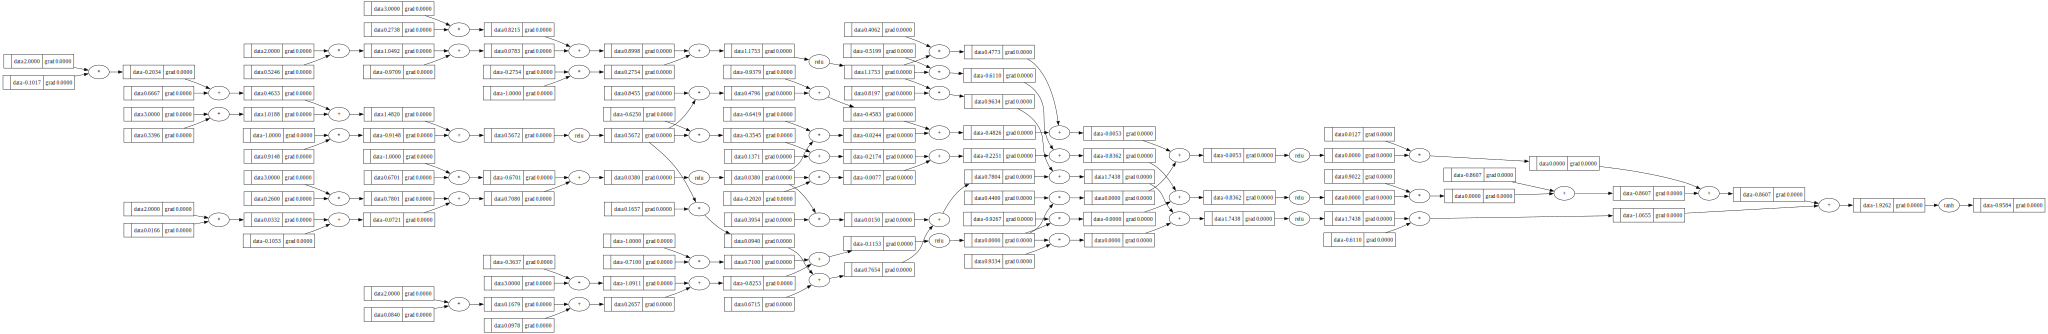

In [42]:
draw_dot(out)

### Example Dataset

In [43]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # so it is a binary classification problem

In [44]:
nn = mlp(3, [4,4,1], activations=["relu","relu","tanh"])

In [45]:
# let us see the predictions of the current initialized weights 
ypreds = [nn(x) for x in xs]
ypreds

[Value:(data=-0.5483754825156838),
 Value:(data=-0.9108717596934065),
 Value:(data=-0.5623107028667292),
 Value:(data=-0.5602521255310596)]

- the key to train this network is to calculate a single number -the loss- that somehow measures the total performance of the network on the dataset 
    - and then we want to calculate the derivatives of that loss w.r.t the weights of the network, and use that information to update the weights -nudge them- in a way that minimizes the loss (if it measures how bad the network is)
    - and as we said above the key is to nudge them in opposite direction 
- the loss that we will use is the sum squared error loss, which is the average of the squared differences between the predictions and the actual labels (mine: binary cross entropy would have been a better choice)

In [46]:
loss = sum([(y_pred - y)**2 for y,y_pred in zip(ys,ypreds)])
loss

Value:(data=5.031369094125033)

- we want to minimize the above number, because it will correspond to better outputs (predictions closer to the actual labels)

In [47]:
loss.backward() # this will calculate the derivaties of the loss to the entire NN (mathematical expression)

In [48]:
# let us see the derivatives of some neuron 
nn.layers[0].neurons[0].w[0].grad

-0.061975512571887346

- we see above the drivative of the loss w.r.t a particular weight in the total weights of the NN, and as we said, we can use that info to nudge the weights in a way that minimizes the loss (by subtracting the derivative multiplied by the learning rate) so we basically nudge a tiny amount based on the gradient information
    - if the derivative is +ve -which means nudging the weight up will increase the loss- we want to nudge the weight down (by subtracting the +ve derivative)
    - if the derivative is -ve -which means nudging the weight up will decrease the loss- we want to nudge the weight up (by subtracting the -ve derivative)
- we will do that for all the weights in the network, as we have the information of the derivative of the loss w.r.t all weights

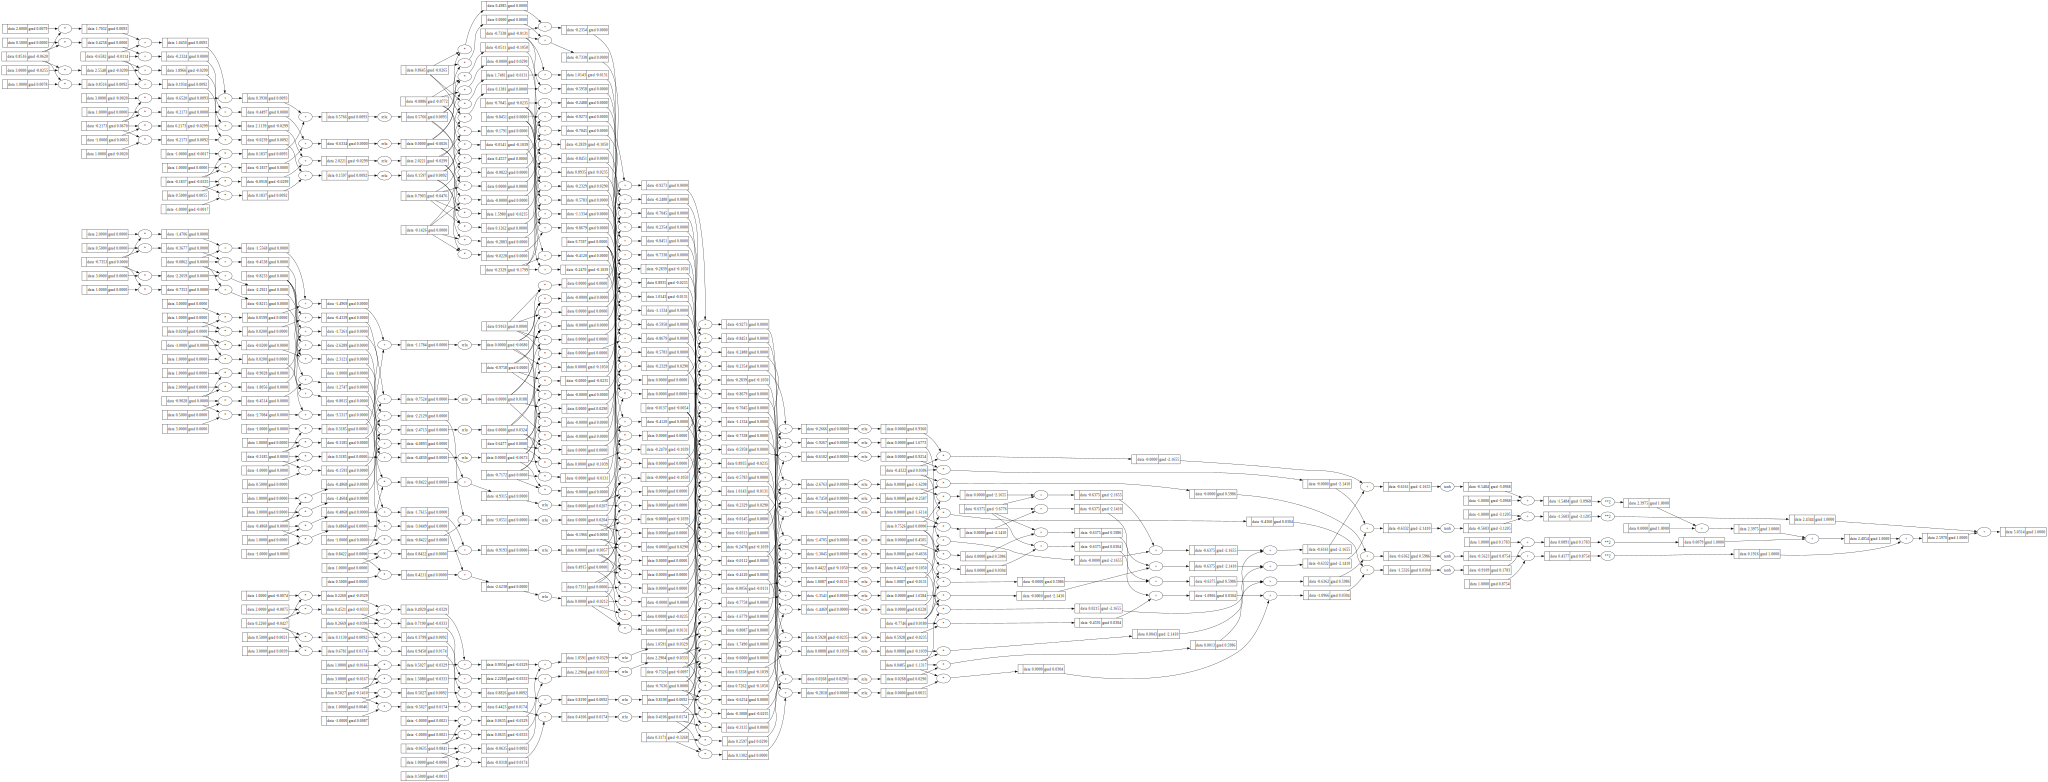

In [49]:
draw_dot(loss)

- the above graph has 4 forward passes of the NN for each example and then the loss on top of all that, and ends with the total loss
     - mine: we summed the losses of all examples and produced a single number (the total loss), but usually we take the average of the losses (mean squared error loss) so that the loss is not affected by the number of examples (if we have more examples the loss will be larger, and we don't want that), and that average loss would be more representative of the performance of the network on all the examples
- theoritically, we can nudge any single variable to minimize the loss, but in practice we usually consider the inputs to be fixed (a given to the problem) and we only nudge the weights (the parameters of the network) to minimize the loss

In [50]:
# lets get the parameters of the NN
nn.parameters()

[Value:(data=0.8515913407956297),
 Value:(data=-0.2173470382148215),
 Value:(data=-0.18365854328357845),
 Value:(data=-0.6581898985864272),
 Value:(data=-0.7353097175460659),
 Value:(data=0.019961164162935363),
 Value:(data=-0.3185117027479416),
 Value:(data=-0.08616099761782281),
 Value:(data=-0.9027980506330868),
 Value:(data=-0.48680020813363245),
 Value:(data=0.8421872852044692),
 Value:(data=-0.8232925945419973),
 Value:(data=0.22603376451558987),
 Value:(data=0.5026580439148989),
 Value:(data=-0.06351496146380642),
 Value:(data=0.26688553929906433),
 Value:(data=-0.14258629070842055),
 Value:(data=0.9162849909028512),
 Value:(data=0.759713713065642),
 Value:(data=-0.7635975193995386),
 Value:(data=-0.8451011828101138),
 Value:(data=0.7902812093192901),
 Value:(data=-0.9758357228724355),
 Value:(data=0.49148556689393996),
 Value:(data=-0.7325556576453864),
 Value:(data=-0.7044941017281219),
 Value:(data=-0.08858043594726972),
 Value:(data=0.6476536969318236),
 Value:(data=-0.19660

- these are all the weights and biases inside the neural network

In [51]:
len(nn.parameters()) # 3*4 + 4 + 4*4 + 4 + 4*1 + 1

41

In [52]:
3*4+4 + 4*4+4 + 4*1+1

41

In [53]:
grads = [param.grad for param in nn.parameters()]
grads

[-0.061975512571887346,
 0.0670402071034745,
 -0.03346751998757636,
 -0.01142423045938875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.04271238934832389,
 -0.14103476886747773,
 0.08413749984445261,
 -0.03961801123239862,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.047550497117816094,
 0.0,
 0.0,
 -0.009654740891207051,
 -0.023515381368360844,
 -0.07715290222336266,
 0.0,
 0.0,
 -0.3267929330599712,
 -0.1798555915453003,
 -0.026533629803406098,
 0.0,
 0.0,
 -0.0053874372757947864,
 -0.013121806536912532,
 0.0,
 0.01799606109759094,
 -1.131702363233062,
 0.030623173778552153,
 -3.677593118130541]

- we can think of these gradients as a vector pointing towards the increase of the loss, and we want to go to the opposite direction of that vector (to minimize the loss)
    - and we can think of the learning rate as the step size of that vector (how much we want to nudge the weights in the opposite direction of the gradient)

In [54]:
nn.layers[0].neurons[0].w[0].data

0.8515913407956297

In [55]:
nn.layers[0].neurons[0].w[0].grad

-0.061975512571887346

In [56]:
# lets manually nudge the paramaters 
for p in nn.parameters():
    p.data -= 0.01 *  p.grad

In [57]:
nn.layers[0].neurons[0].w[0].data

0.8522110959213486

In [65]:
# calculate the new loss (hopefully it got better)
# let us see the predictions of the current initialized weights 
ypreds = [nn(x) for x in xs]
loss = sum([(y_pred - y)**2 for y,y_pred in zip(ys,ypreds)])
loss

Value:(data=4.567190481273878)

### iteratively training the network (manual)

In [66]:
## forward pass and loss calculation
ypreds = [nn(x) for x in xs]
loss = sum([(y_pred - y)**2 for y,y_pred in zip(ys,ypreds)])
loss

Value:(data=4.567190481273878)

In [67]:
## back prop and derivative calculation 
loss.backward()

In [68]:
## update parameters (nudge)
# lets manually nudge the paramaters 
for p in nn.parameters():
    p.data -= 0.01 *  p.grad

In [69]:
## lets plot y_prid after training
ypreds, ys

([Value:(data=-0.45165153140208186),
  Value:(data=-0.8928603435553547),
  Value:(data=-0.4801704358357758),
  Value:(data=-0.4758714818335722)],
 [1.0, -1.0, -1.0, 1.0])

### training loop

In [70]:
# reinitialize the neural net
nn = mlp(3, [4,4,1], activations=['relu','relu','tanh'])

In [82]:
epochs = 100
for k in range(epochs):
    ## forward pass and loss calculation
    ypreds = [nn(x) for x in xs]
    loss = sum([(y_pred - y)**2 for y,y_pred in zip(ys,ypreds)])

    ## back prop and derivative calculation 
    # Zero-grad the parameters before calculating the next step gradient
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()

    # parameters update (nudge)
    for p in nn.parameters():
        p.data -= 0.05 *  p.grad
    
    print(k, loss.data)

ypreds,ys

0 0.0014769798327521513
1 0.0014754088348985061
2 0.0014738437651705498
3 0.0014722820172316572
4 0.0014707235803057455
5 0.0014691684436650891
6 0.0014676165966303642
7 0.001466068028570099
8 0.0014645227289005105
9 0.0014629806870852429
10 0.0014614418926349713
11 0.0014599063351072605
12 0.001458384142758336
13 0.0014575635350955367
14 0.0014560328051730568
15 0.001454505298888446
16 0.001452981005817205
17 0.0014514599155819445
18 0.001449942017852343
19 0.0014484273023445968
20 0.0014469157588212268
21 0.00144540737709081
22 0.0014439021470077393
23 0.0014424000584718983
24 0.0014409011014284109
25 0.0014394052658672184
26 0.0014379125418231206
27 0.0014364229193752373
28 0.0014349363886468555
29 0.0014334529398050515
30 0.0014319725630606464
31 0.0014304952486677166
32 0.0014290232781851602
33 0.0014275545017600776
34 0.0014260887438440094
35 0.0014246259949713795
36 0.0014231662457178701
37 0.0014217094866999119
38 0.0014202557085745255
39 0.001418804902039214
40 0.0014173570578

([Value:(data=0.9747950001229266),
  Value:(data=-0.9999889264148526),
  Value:(data=-0.9917921429109583),
  Value:(data=0.9747950001229266)],
 [1.0, -1.0, -1.0, 1.0])

- there is a new important concept here, which is zero-gradding the gradients before any .backward() call
    - all of the parameters have a .data and .grad (initialized as 0), and when we do .backward() remember that we accumulate the gradients (in case a variable receives the gradient from multiple paths) 
    - but after calculating .backward() and updating the weights, we want to set the gradients again to 0 before accumulating the gradients of the next iteration (otherwise the gradients will keep adding up and will never reset to 0, which will be wrong estimation of the next iteration gradients, mine: and might make the updates explode since we take bigger and bigger steps)
        - so before each .backward() call we do a zero-gradding of the gradients (for the first step it is 0 anyway, so its not harmful, but for the following steps it is important) mine: also remember to do it before not after because we need the gradients for the parameter update